In [105]:
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from one.api import ONE
from brainbox.io.one import SessionLoader

sys.path.append('~/code/ibl-photometry')
import iblphotometry.loaders as loaders
import iblphotometry.processing as proc
import iblphotometry.pipelines as pipe

from util import load_recinfo

## Setting up and instantiating a ONE database connection

In [3]:
# Set up the default database URL, local cache dir, and access credentials using
# ONE.setup()

In [4]:
# Instantiate a database connection
one = ONE()

Downloading: /home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/tmp9sqvidhv/cache.zip Bytes: 138028737


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 131.63446140289307/131.63446140289307 [03:32<00:00,  1.61s/it]


## Querying a database using ONE

List of IBL datset types/ tables: https://docs.google.com/document/d/1OqIqqakPakHXRAwceYLwFY9gOrm8_P62XIfCTnHwstg/

The `one.search()` method only queries `session` endpoint. For more complex queries use `one.alyx.rest` method: https://int-brain-lab.github.io/ONE/notebooks/one_advanced/one_advanced.html#

#### Cheatsheet
- partial dataset names may be used
- using `'trials.table'` gets only completed sessions (?)
- `'wheel'` is raw wheel data
- for cameras use e.g. `'_ibl_*Camera'` where `*` is `'left'`, `'right'`, or `'body'`
- video-based data includes `'camera.raw'` for video data, `'camera.dlc'` for keypoint tracking, `'camera.ROIMotionEnergy'` for ME, or `'licks.times'` for licks detected via DLC tongue marker
- some task protocol stems: `'trainingChoice'`, `'ephysChoice'`, `'biasedChoice'`
- `dataset_qc_lte` is quality control parameter

In [6]:
# Get possible QC values for query
from one.alf import spec
print([q for q in spec.QC])

[<QC.CRITICAL: 50>, <QC.FAIL: 40>, <QC.WARNING: 30>, <QC.NOT_SET: 0>, <QC.PASS: 10>]


### Fiber photometry
So far, this data only lives on the IBL server at CCU, so we mount the server and point ONE to the mounted cache_dir.

In [88]:
cache_dir = '/mnt/iblserver'
one = ONE(cache_dir=cache_dir)

In [13]:
eids, infos = one.search(
    lab='mainenlab',
    projects='ibl_fibrephotometry',
    dataset='trials',
    dataset_qc_lte='PASS',
    query_type='local', 
    details=True
)

In [89]:
df_recinfo = load_recinfo()

In [98]:
eid = df_recinfo['eid'][0]
loader = loaders.KceniaLoader(one)
photometry = loader.load_photometry_data(eid)

In [136]:
signal_raw = photometry['raw_calcium']['Region4G']
tpts = photometry['raw_calcium'].index.values

In [114]:
pipeline = [
        (
        proc.lowpass_bleachcorrect,
        dict(
            correction_method='subtract',
            filter_params=dict(N=3, Wn=0.01, btype='lowpass'),
            )
        )
]

In [115]:
photometry_proc = pipe.run_pipeline(pipeline, photometry['raw_calcium'])
signal_proc = photometry_proc['Region4G']

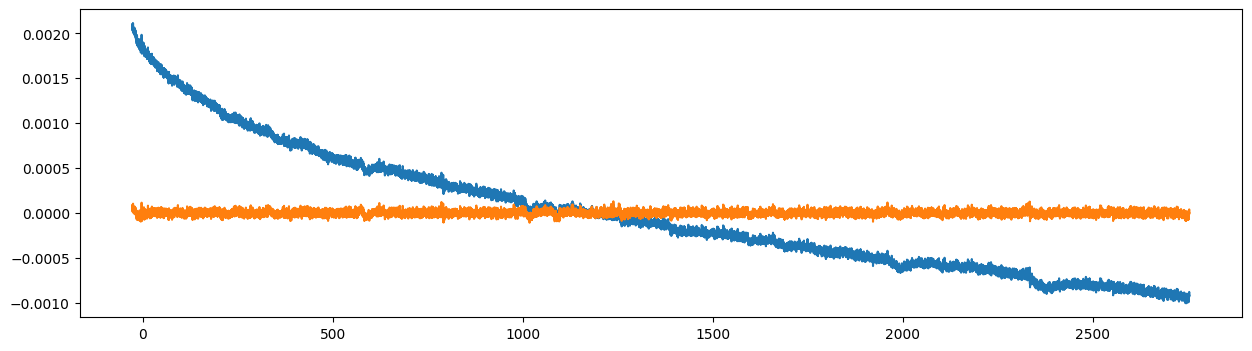

In [120]:
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(tpts, signal_raw - signal_raw.mean())
ax.plot(tpts, signal_proc)

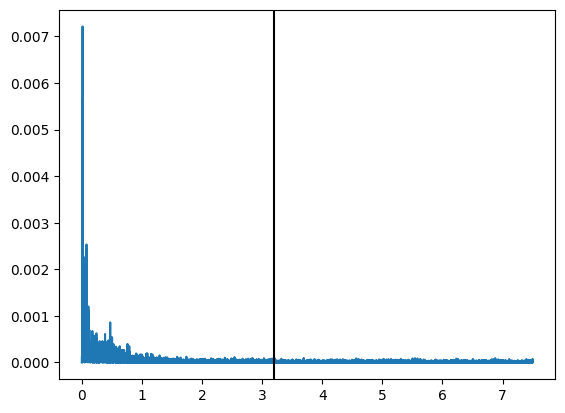

In [152]:
CUTOFF = 3.2
dt = np.median(np.diff(tpts))
n_pts = len(signal_proc)
freqs = np.fft.rfftfreq(n_pts, dt) 
psd = np.abs(np.fft.rfft(signal_proc - signal_proc.mean())) ** 2

fig, ax = plt.subplots()
ax.plot(freqs, psd)
ax.axvline(CUTOFF, color='black')

psd[freqs <= CUTOFF].mean() / psd[freqs > CUTOFF].mean() 

### Task performance
Query for all `ibl_fiberphotometry` experiments that pass QC.

In [19]:
eids, infos = one.search(
    lab='mainenlab',
    projects='ibl_fibrephotometry',
    dataset='trials',
    dataset_qc_lte='PASS',
    query_type='local', 
    details=True
)

# Place all metadata in a dataframe
df_eids = pd.DataFrame(infos)
df_eids['eid'] = eids
print(f"Number of sessions: {len(df_eids)}")
print(f"Number of mice: {len(df_eids.groupby('subject'))}")
# print(df_eids['subject'].unique())

Number of sessions: 2192
Number of mice: 31


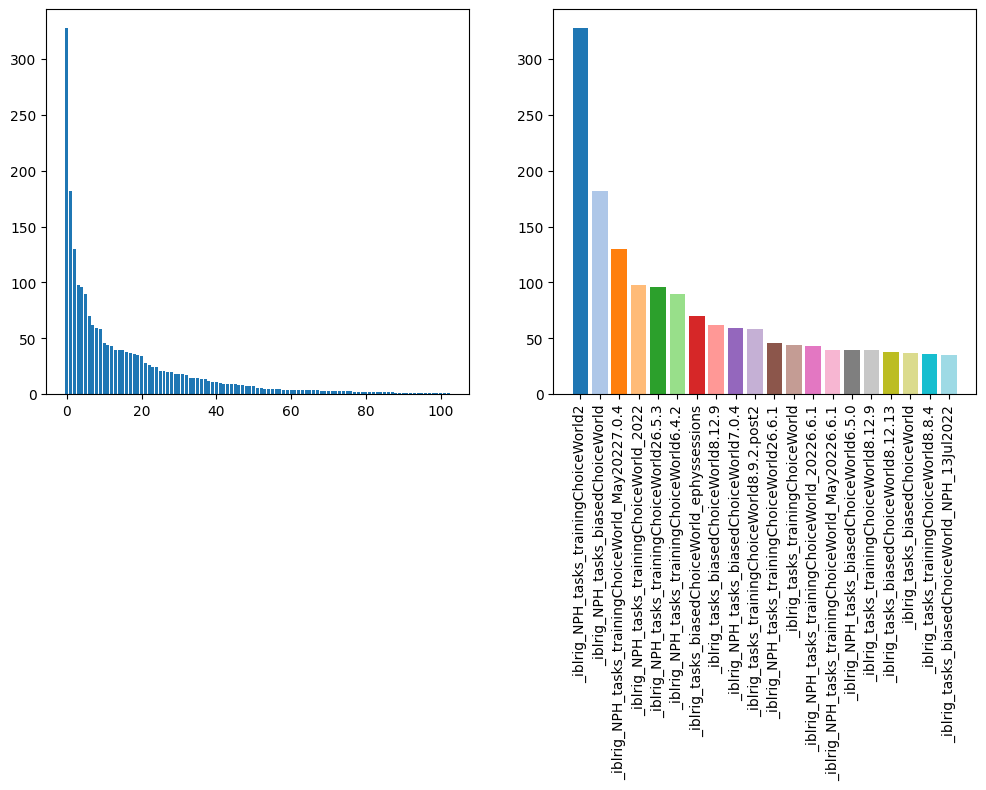

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
df_protocols = df_eids['task_protocol'].value_counts()
axs[0].bar(np.arange(len(df_protocols)), df_protocols.values)
axs[1].bar(np.arange(20), df_protocols.head(20).values, color=plt.cm.tab20(np.arange(20)))
axs[1].set_xticks(np.arange(20))
axs[1].set_xticklabels(df_protocols.head(20).index)
axs[1].tick_params(axis='x', labelrotation=90)

In [ ]:
# df_eids['data_exists'] = True
agg_dict = {
    'correct': 'mean',  # proportion correct
    'date': 'first',
    'task_protocol': 'first'
    }

for mid, mouse in df_eids.groupby('subject'):
    df_trials = pd.DataFrame()
    for _, session in mouse.iterrows():
        try:
            loader = SessionLoader(one=one, eid=session['eid'])
            loader.load_trials()
        except:
            # df_eids.loc[idx, 'data_exists'] = False
            continue
        df = loader.trials
        for data_label in ['subject', 'date', 'eid', 'task_protocol']:
            df[data_label] = session[data_label]
        df_trials = pd.concat([df_trials, df])
    
    df_trials = df_trials.reset_index().rename(columns={'index':'trial_n'})
    df_trials['contrast'] = df_trials.apply(lambda x: np.nansum([x['contrastLeft'], x['contrastRight']]), axis='columns')
    df_trials['correct'] = df_trials['feedbackType'] > 0
    df_trials = df_trials.sort_values('date')
    # df_trials.to_csv(f'data/{mid}.csv')

    break

    # df_learn = df_trials.query('contrast == 1').groupby('eid', sort=False).agg(agg_dict)
    # df_learn = df_learn.query("not task_protocol.str.contains('habituation')")

    # fig, ax = plt.subplots()
    # ax.plot(df_learn['correct'].values)
    # ax.tick_params(axis='x', labelrotation=60)

/home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZF
/home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZF
/home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZF
/home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZF
/home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZF
/home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZF
/home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZF
/home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZF
/home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZF
/home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZF
/home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZF
/home/crombie/Downloads/ONE/alyx.internationalbrainlab.org/mainenlab/Subjects/ZF
/home/crombie/Downloads/ONE/